In [27]:
#importing data for time series 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import plotly as pl
import statsmodels
import statsmodels.api as sm
import itertools

In [28]:
#modules for time series analysis
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6
from datetime import datetime
from statsmodels.tsa.stattools import acf, pacf

In [29]:
import os
cwd = os.getcwd()
cwd
# Import the time series data
jc = 'jcdatapy.csv'
data = pd.read_csv(jc)
data

,Date,Sales,Intent,Spend
0,2016-04-01,74340.71,21.91,545664.31
1,2016-05-01,113533.76,18.88,607878.90
2,2016-06-01,140037.02,22.86,1396676.84
3,2016-07-01,69381.41,16.45,604576.71
4,2016-08-01,91231.26,22.04,50865.61
5,2016-09-01,111881.62,24.01,128123.82
6,2016-10-01,139031.59,30.44,43473.00
7,2016-11-01,144009.79,22.41,702704.00
8,2016-12-01,210135.72,22.15,986849.00
9,2017-01-01,93679.79,36.99,676841.19


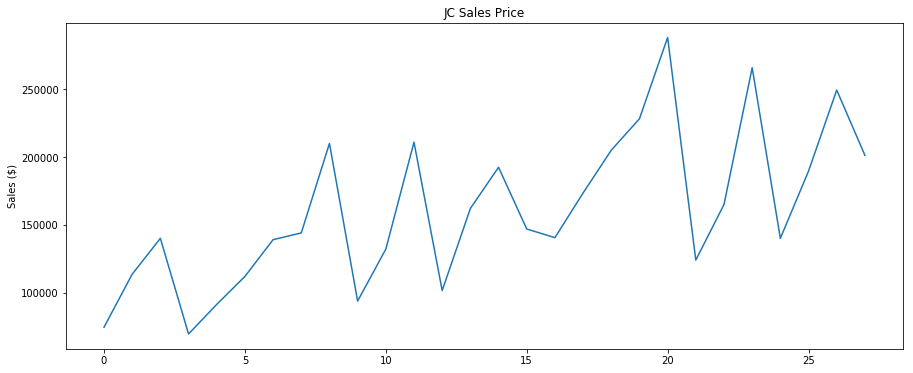

In [30]:
plt.plot(data.index, data['Sales'])
plt.title('JC Sales Price')
plt.ylabel('Sales ($)');
plt.show()

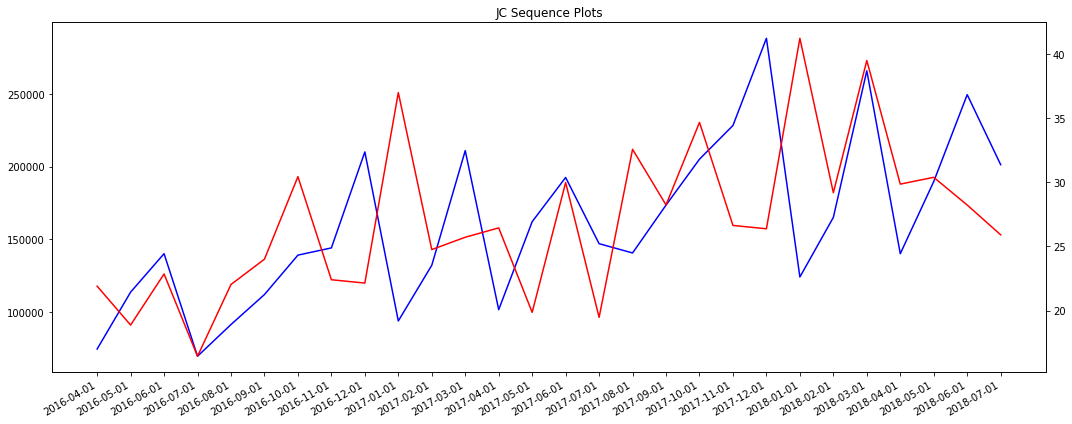

In [32]:
# Sequence plot assuming unequal scales
plt.close('all')
fig, ax1 = plt.subplots()
t = data['Date']
ax1.plot(t, data['Sales'], 'b-', label='Sales')
fig.autofmt_xdate()
ax1.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')


ax2 = ax1.twinx()
ax2.plot(t, data['Intent'], 'r-', label = 'Intent')

plt.title('JC Sequence Plots')
fig.tight_layout()
plt.show()


In [15]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')  #parse the time data into the correct format
data = pd.read_csv('jcdatapy.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse) #load the parsed data
data #check that it looks right
data.index #dtype must return datetime64[ns]

ts_sales = data['Sales']  #convert to univariate series object

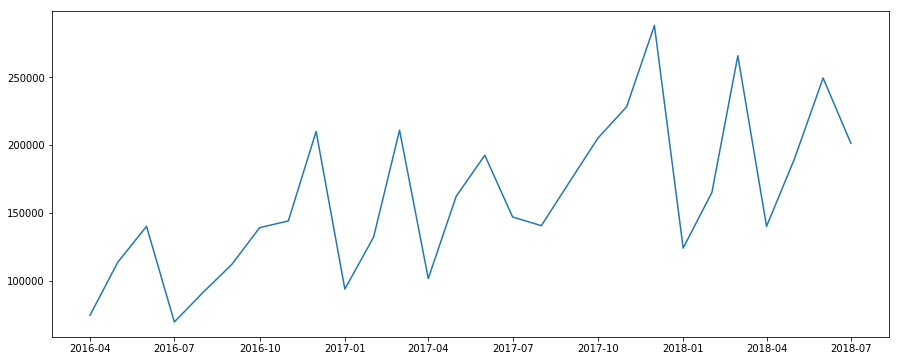

In [16]:
plt.plot(ts_sales)
plt.show()


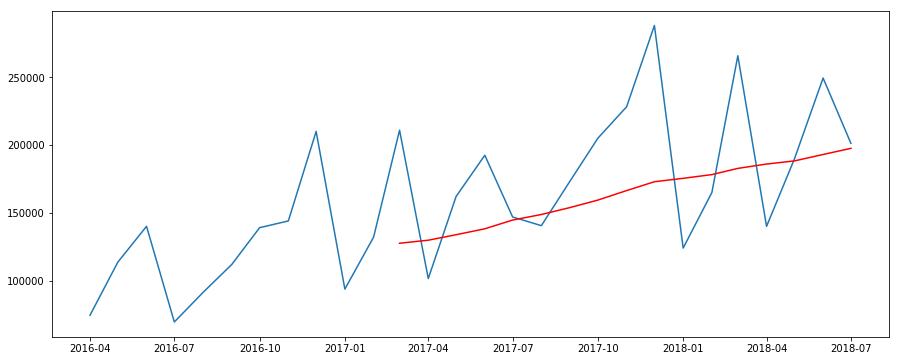

In [17]:
rolmean = ts_sales.rolling(12).mean()
plt.plot(ts_sales)
plt.plot(rolmean, color='red')
plt.show()

c:\users\rcluk\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



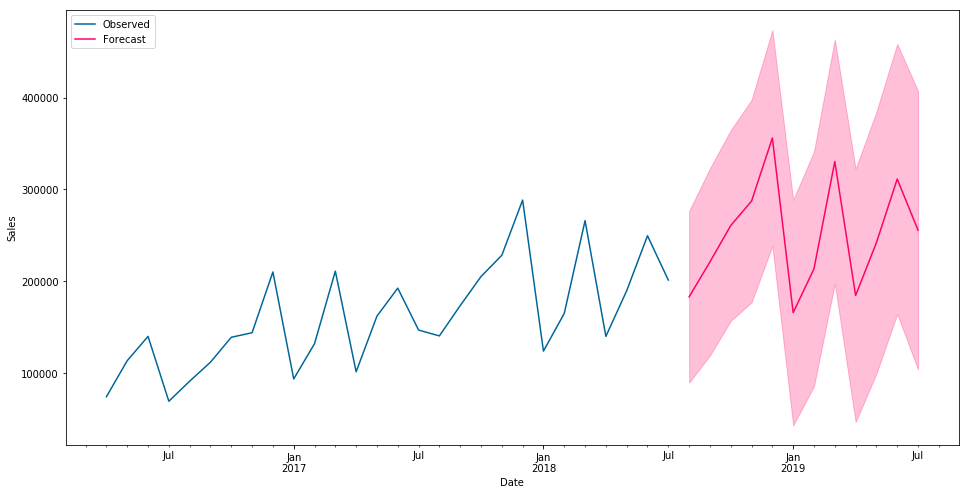

In [18]:
y = data['Sales'] 

res = sm.tsa.statespace.SARIMAX(ts_sales, order=(2,1,1), seasonal_order=(1,0,0,12), enforce_stationarity=False, enforce_invertability=False).fit()

# in-sample-prediction and confidence bounds
pred = res.get_prediction(start=pd.to_datetime('2016-04-01'), end=pd.to_datetime('2018-07-01'),dynamic=True)

#Get forecast 12 periods into the future
pred_uc = res.get_forecast(steps=12)

#Get Confidence Intervals of forecasts
pred_ci = pred_uc.conf_int()


#Plot time series and long-term forecast
ax = y.plot(label='Observed', figsize=(16, 8), color='#006699');
pred_uc.predicted_mean.plot(ax=ax, label='Forecast', color='#ff0066')
ax.fill_between(pred_ci.index, pred_ci.iloc[:, 0],pred_ci.iloc[:, 1], color='#ff0066', alpha=.25);
ax.set_xlabel('Date');
ax.set_ylabel('Sales');
plt.legend(loc='upper left')
plt.show()

                                 Statespace Model Results                                 
Dep. Variable:                              Sales   No. Observations:                   28
Model:             SARIMAX(2, 1, 1)x(1, 0, 0, 12)   Log Likelihood                -152.710
Date:                            Wed, 14 Nov 2018   AIC                            315.419
Time:                                    18:43:20   BIC                            318.244
Sample:                                04-01-2016   HQIC                           314.839
                                     - 07-01-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1010      2.540     -0.040      0.968      -5.078       4.876
ar.L2         -0.2758      4.223   

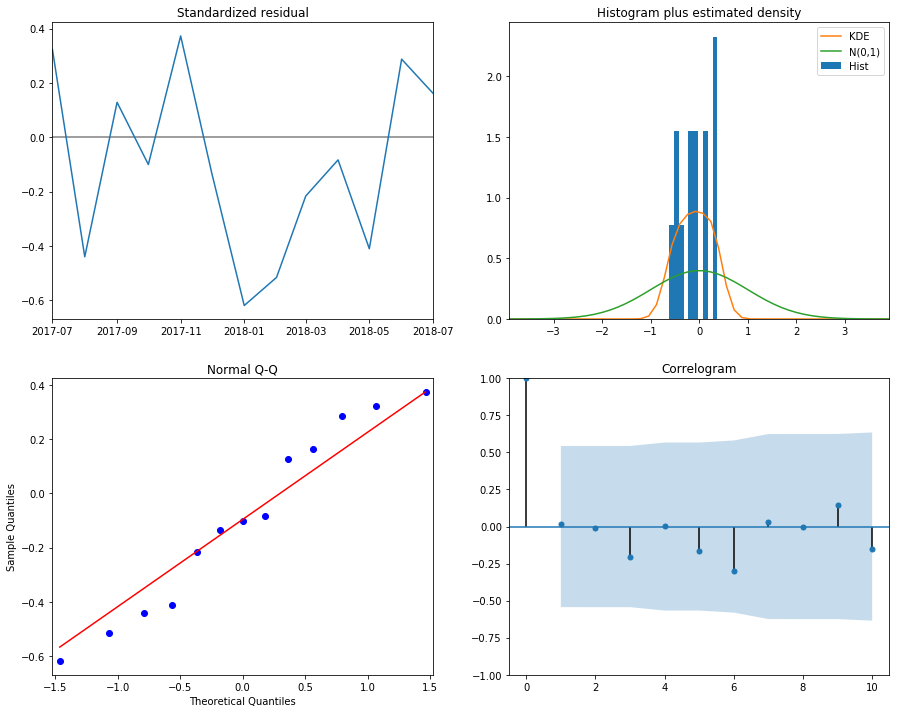

In [19]:
print(res.summary())
#print(ts_sales)
res.plot_diagnostics(figsize=(15,12))
plt.show()

In [20]:
pred = res.get_prediction(start=pd.to_datetime('2016-04-01'),dynamic=False)
pred_ci = pred.conf_int()

In [21]:
y_forecasted = pred.predicted_mean
y_truth = y
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 1746572060.7
